# CPS2.2 - Computer Problem Set 2.2
### **Girsanov Theorem**

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [46]:
# ------ Variables ------ #

M = 10000    # Number of simulations
S0 = 100    # Initial stock price
r = 0.02    # Risk-free rate
sigma = 0.4 # Volatility
T = 2       # Time to maturity
n = 100     # Number of time steps

# ----------------------- #

## 1 - Monte Carlo Approximation of $\Delta_0$ using $\Delta_0 = P[S_T\ge K]$

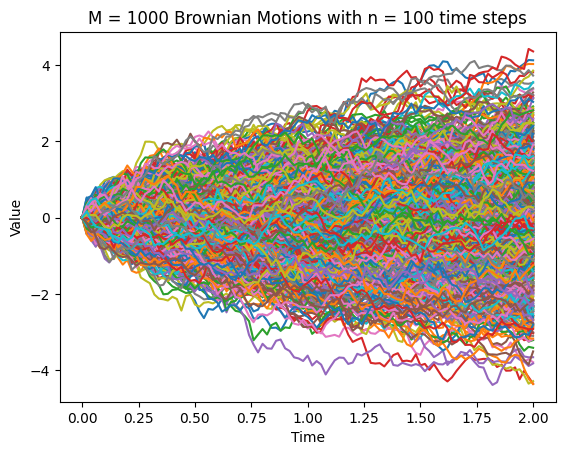

In [5]:
# Creating our M Brownian Motions 
def create_W(M,n,T):
    W = np.zeros((n+1,M))
    dt = T/n
    W[1:n+1,:] = np.sqrt(dt)*np.random.randn(n,M)
    W = np.cumsum(W,axis=0)
    return W

# Plotting the Brownian Motions for verification
plt.figure()
plt.plot(np.linspace(0,T,n+1),create_W(M,n,T))
plt.title('M = ' + str(M) + ' Brownian Motions' + ' with ' + 'n = ' +str(n) + ' time steps')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

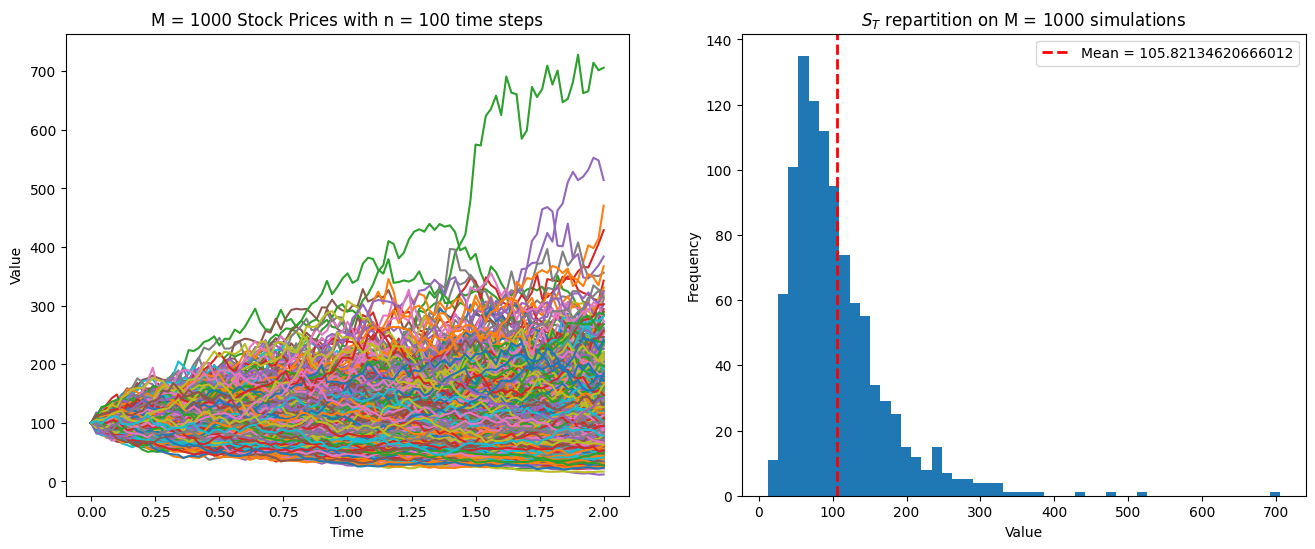

In [6]:
# Creating our M Stock Prices Paths
def create_S(M,n,T,r,sigma):
    S = np.zeros((n+1,M))
    dt = T/n
    W = create_W(M,n,T)
    S[0,:] = S0
    for i in range(1,n+1):
        S[i,:] = S[i-1,:] + S[i-1,:]*(r*T/n + sigma * (W[i,:] - W[i-1,:]))
    return S,W

S,W = create_S(M,n,T,r,sigma)

# Plotting the M Stock Prices
plt.figure(12,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,T,n+1),S)
plt.title('M = ' +str(M) + ' Stock Prices' + ' with n = ' + str(n) + ' time steps')
plt.xlabel('Time')
plt.ylabel('Value')

# Plotting S(T) for verification
plt.subplot(1,2,2)
plt.hist(S[-1,:] , bins = 50)

# Plotting the mean axis
plt.axvline(np.mean(S[-1,:]), color='r', linestyle='dashed', linewidth=2)
plt.title('$S_T$ repartition on M = 1000 simulations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['Mean = ' + np.mean(S[-1,:]).astype(str)])
plt.show()


In [29]:
def monte_carlo(M,n,T,r,sigma,K):
    S,W = create_S(M,n,T,r,sigma)
    count = np.sum(S[-1,:]>K)
    return count/M

K = 150     # Strike price
print('With this method, the probability approximation that the stock price is above K = ' + str(K) +' is : Delta_0 = ',monte_carlo(M,n,T,r,sigma,K))

With this method, the probability approximation that the stock price is above K = 150 is : Delta_0 =  0.182


## 2 - Monte Carlo Approximation of $\Delta_0$ using $\Delta_0 = E^{Q^{\theta}}[ (Z^{\theta})^{-1} \mathbb{1}_{\{S_T \geq K\}}]$

In [12]:
# Real value of Delta_0 
def Delta_0(r,sigma,K,T):
    if sigma == 0:
        return 1*(np.log(K/S0) - r*T <= 0)
    if sigma > 0:
        d1 = (np.log(K/S0) - r*T)/sigma
        return 1 - norm.cdf(d1)
    else:
        d1 = (np.log(K/S0) - r*T)/sigma
        return norm.cdf(d1) 
    

print("The real value of Delta_0 is : ",Delta_0(r,sigma,K,T))

def create_W_theta(M,n,T,theta):
    W = np.zeros((n+1,M))
    dt = T/n
    W[1:n+1,:] = np.sqrt(dt)*np.random.randn(n,M)
    W = np.cumsum(W,axis=0)
    for i in range(n+1):
        W[i,:] = W[i,:] + theta * i * dt
    return W

def create_S_theta(M,n,T,r,sigma,theta):
    S = np.zeros((n+1,M))
    dt = T/n
    W = create_W_theta(M,n,T,theta)
    S[0,:] = S0
    for i in range(1,n+1):
        S[i,:] = S[i-1,:] + S[i-1,:]*(r*T/n + sigma * (W[i,:] - W[i-1,:]))
    return S,W

def create_Z_theta(M,n,T,r,sigma,theta):
    S,W = create_S_theta(M,n,T,r,sigma,theta)
    Z = np.zeros(M)
    for i in range(M):
        Z[i] = np.exp(theta*W[-1,i]-(theta**2)*T/2)
    return Z,S

def monte_carlo_theta(M,n,T,r,sigma,K,theta):
    Z,S = create_Z_theta(M,n,T,r,sigma,theta)
    out = 0
    for i in range(M):
        if S[-1,i] >= K:
            out += 1/Z[i] 
    return out/M

K = 150
theta = 1
print("The approximation of Delta_0 with theta = " + str(theta) + " is : ",monte_carlo_theta(M,n,T,r,sigma,K,theta))

The real value of Delta_0 is :  0.18044703614977498
The approximation of Delta_0 with theta = 1 is :  0.17597955501576895


## 3 - Difference between the Monte Carlo estimator and the true value of $\Delta_0$

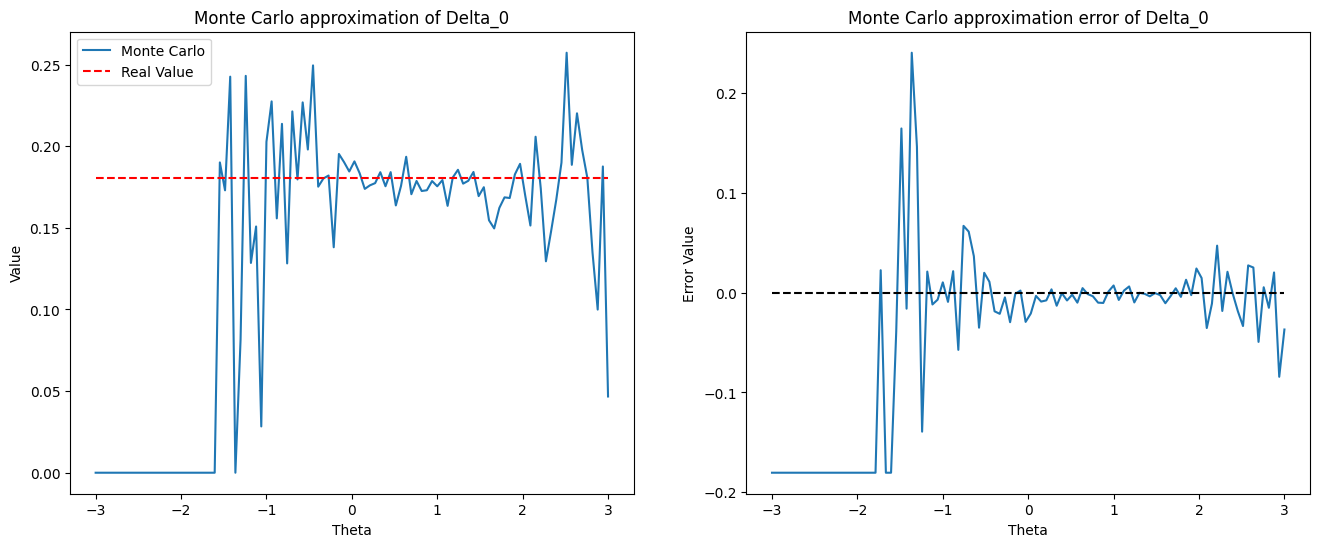

In [28]:
theta_numb = 100
range_theta = np.linspace(-3,3,theta_numb)

plt.figure(12,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_theta,[monte_carlo_theta(M,n,T,r,sigma,K,theta) for theta in range_theta])
plt.plot(range_theta,[Delta_0(r,sigma,K,T) for theta in range_theta], 'r--')
plt.title('Monte Carlo approximation of Delta_0')
plt.xlabel('Theta')
plt.ylabel('Value')
plt.legend(['Monte Carlo','Real Value'])

plt.subplot(1,2,2)
plt.plot(range_theta,[monte_carlo_theta(M,n,T,r,sigma,K,theta) - Delta_0(r,sigma,K,T) for theta in range_theta])
plt.plot(range_theta,np.zeros(theta_numb),'--', color = 'black')
plt.title('Monte Carlo approximation error of Delta_0')
plt.xlabel('Theta')
plt.ylabel('Error Value')
plt.show()

## 4 - Monte Carlo approximation of $V^{\theta}$

In [32]:
def monte_carlo_variance(M,n,T,r,sigma,K,theta):
    Z,S = create_Z_theta(M,n,T,r,sigma,theta)
    out = 0
    for i in range(M):
        if S[-1,i] >= K:
            out += Z[i]**(-2)
    return out/M - Delta_0(r,sigma,K,T)**2
            
print("The variance of Delta_0 with theta = 0.5 is : ",monte_carlo_variance(M,n,T,r,sigma,K,theta))
        


The variance of Delta_0 with theta = 0.5 is :  0.0362988635253736


## 5 - Effect of $\theta$ on the Variance $V^{\theta}$

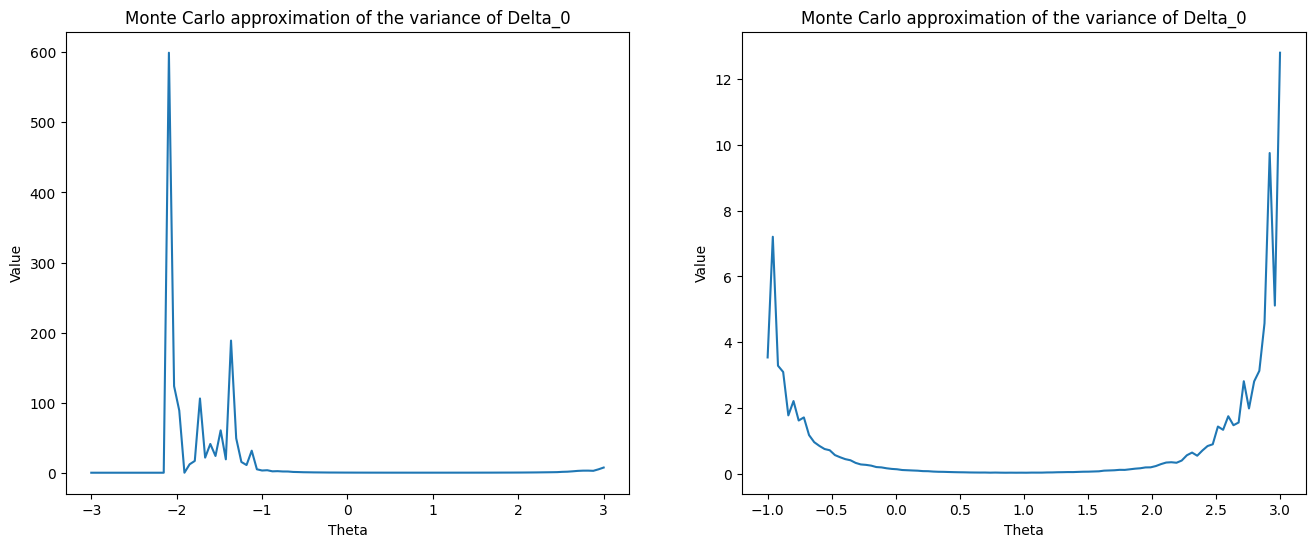

In [47]:
range_theta_1 = np.linspace(-3,3,100)
range_theta_2 = np.linspace(-1,3,100)

plt.figure(12,figsize=(16,6))
# Figure 1
plt.subplot(1,2,1)
plt.plot(range_theta_1,[monte_carlo_variance(M,n,T,r,sigma,K,theta) for theta in range_theta_1])
plt.title('Monte Carlo approximation of the variance of Delta_0')
plt.xlabel('Theta')
plt.ylabel('Value')
# Figure 2 ( Zoom on the interesting part)
plt.subplot(1,2,2)
plt.plot(range_theta_2,[monte_carlo_variance(M,n,T,r,sigma,K,theta) for theta in range_theta_2])
plt.title('Monte Carlo approximation of the variance of Delta_0')
plt.xlabel('Theta')
plt.ylabel('Value')
plt.show()

It seems that there is a great instability of $V^{\theta}$ on $[-2.2:-1]$ and that the Variance minima is achieved in ${\theta} = 1$. This scheme seems to be stable in terms of the sample size M. Let's trace the same graphs for $M \in \{10,100,1000,10000\}$ : 

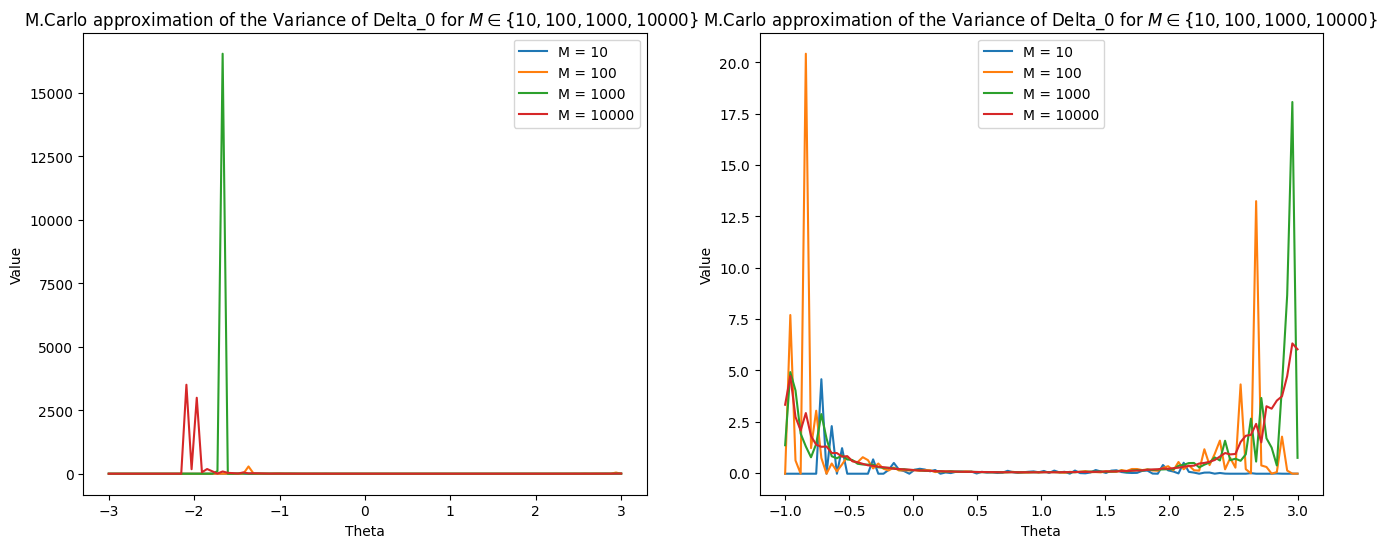

In [60]:
list_M = [10,100,1000,10000]

plt.figure(12,figsize=(16,6))
plt.subplot(1,2,1)
for M in list_M:
    plt.plot(range_theta_1,[monte_carlo_variance(M,n,T,r,sigma,K,theta) for theta in range_theta_1])
    plt.title('M.Carlo approximation of the Variance of Delta_0 for $M \in \{10,100,1000,10000\}$  ')
plt.xlabel('Theta')
plt.ylabel('Value')
plt.legend(['M = ' + str(M) for M in list_M])

plt.subplot(1,2,2)
for M in list_M:
    plt.plot(range_theta_2,[monte_carlo_variance(M,n,T,r,sigma,K,theta) for theta in range_theta_2])
    plt.title('M.Carlo approximation of the Variance of Delta_0 for $M \in \{10,100,1000,10000\}$ ')
plt.xlabel('Theta')
plt.ylabel('Value')
plt.legend(['M = ' + str(M) for M in list_M])
plt.show()

Tho value of $\theta$ thats optimizes $V^{\theta}$ is stable in terms of M and is $\theta=1$. To get the best approximation, it is in our interest to set $\theta$ to 1 when computing $\Delta_0$